In [50]:
import numpy as np
import pandas as pd
import geopandas as gpd
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.api import abline_plot 
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.model_selection import train_test_split 
from sklearn import linear_model, preprocessing 
from datetime import datetime, timezone

For context https://github.com/UnacceptableVegetable/SpringBoard/blob/main/Capstone%20Two/data_wrangling.ipynb

I decided that I should focus on only the San Francisco station (for now), so I needed to be able to read the large CSV file and then write a new CSV file with only SFO's station data and nearby PM2.5 recordings.

In [7]:
#import dask.dataframe as dd
#df = dd.read_csv('df.csv')
#df_SF = df[df['station']=='SFO']
#df_SF.to_csv("df_SF.csv",index_label=False,single_file=True)

In [17]:
df = pd.read_csv('df_SF.csv')

In [18]:
df.head()

date  DS_PM_pred  DS_PM_stdd       lon       lat station  \
84917819  2019-01-01       4.028      2.1545 -122.5131  37.86929     SFO   
84917820  2019-01-01       4.028      2.1545 -122.5131  37.86929     SFO   
84917821  2019-01-01       4.028      2.1545 -122.5131  37.86929     SFO   
84917822  2019-01-01       4.028      2.1545 -122.5131  37.86929     SFO   
84917823  2019-01-01       4.028      2.1545 -122.5131  37.86929     SFO   

                        valid  tmpf   relh   drct   sped  
84917819  2019-01-01 00:56:00  54.0  41.11  350.0  19.55  
84917820  2019-01-01 01:56:00  54.0  42.98  350.0  21.85  
84917821  2019-01-01 02:56:00  53.0  40.96  350.0  28.75  
84917822  2019-01-01 03:56:00  53.0  42.48  360.0  27.60  
84917823  2019-01-01 04:56:00  52.0  46.25  360.0  21.85

In [23]:
df.drop('station',axis=1,inplace=True)

In [26]:
df.columns

Index(['date', 'DS_PM_pred', 'DS_PM_stdd', 'lon', 'lat', 'valid', 'tmpf',
       'relh', 'drct', 'sped'],
      dtype='object')

In [27]:
df.valid = pd.to_datetime(df.valid)

In [28]:
report = df[['DS_PM_pred', 'DS_PM_stdd', 'lon', 'lat', 'valid', 'tmpf',
       'relh', 'drct', 'sped']].profile_report(
    sort=None, html={"style": {"full_width": True}}, progress_bar=False
)
report

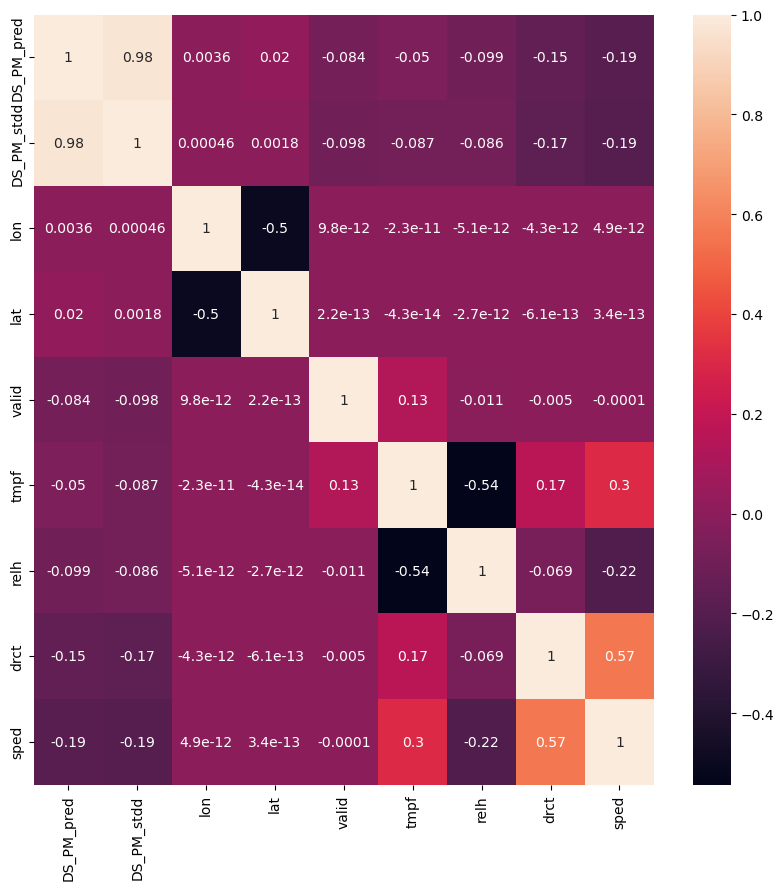

In [94]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True)
plt.show()

For 'sm.OLS' we need the datetime to be a float.

In [51]:
df['valid'] = [dt.replace(tzinfo=timezone.utc).timestamp() for dt in df['valid']]

In [53]:
df.head()

date  DS_PM_pred  DS_PM_stdd       lon       lat  \
84917819  2019-01-01       4.028      2.1545 -122.5131  37.86929   
84917820  2019-01-01       4.028      2.1545 -122.5131  37.86929   
84917821  2019-01-01       4.028      2.1545 -122.5131  37.86929   
84917822  2019-01-01       4.028      2.1545 -122.5131  37.86929   
84917823  2019-01-01       4.028      2.1545 -122.5131  37.86929   

                 valid  tmpf   relh   drct   sped  
84917819  1.546304e+09  54.0  41.11  350.0  19.55  
84917820  1.546308e+09  54.0  42.98  350.0  21.85  
84917821  1.546311e+09  53.0  40.96  350.0  28.75  
84917822  1.546315e+09  53.0  42.48  360.0  27.60  
84917823  1.546319e+09  52.0  46.25  360.0  21.85

In [59]:
X = df.drop(["DS_PM_pred", "DS_PM_stdd",'date','lon','lat'],axis=1)
X = sm.add_constant(X)

In [60]:
y = df[["DS_PM_pred"]]

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123)

In [62]:
model = sm.OLS(y_train.astype(float), X_train.astype(float))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             DS_PM_pred   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                 4.685e+04
Date:                Wed, 10 Jan 2024   Prob (F-statistic):               0.00
Time:                        22:47:40   Log-Likelihood:            -1.2101e+07
No. Observations:             3123792   AIC:                         2.420e+07
Df Residuals:                 3123786   BIC:                         2.420e+07
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        110.6091      0.563    196.597      0.000     109.506     111.712
valid      -5.075e-08   3.67e-10   -138.170      0.000   -5.15e-08      -5e-08
tmpf          -0.1289      0.001   -113.986      0.000      -0.131      -0.127
relh          -0.1510      0.001   -280.564      0.000      -0.152      -0.150
drct          -0.0064   7.54e-05    -85.332      0.000      -0.007      -0.006
sped          -0.3014      0.001   -251.315      0.000      -0.304      -0.299
==============================================================================
Omnibus:                  4008276.833   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        668850341.616
Skew:                           7.267   Prob(JB):                         0.00
Kurtosis:                      73.196   Cond. No.                     1.32e+11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.32e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Given the $R^2$ value is so small, perhaps a linear regression is not the way to go. A neural net with some short term memory for previous days should be factored into the PM2.5 reading, more so than the weather factors of the current day/reading.

In [81]:
rModel = linear_model.LinearRegression()
rModel.fit(X_train, y_train)
rModel.score(X_train, y_train)

0.06975630885583306

As a silly excercise: a graph of the predicted vs actual data in the linear regression, with red being a perfect match.

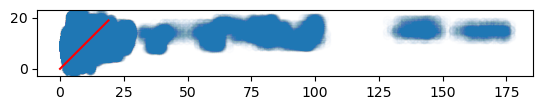

In [95]:
y_pred = rModel.predict(X_test)
plt.scatter(y_test,y_pred,alpha=.01)
plt.plot([x for x in range(0,20)],[x for x in range(0,20)], color='red')
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.show()